## Using Facebook's prophet to predict Schiphol passenger numbers

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [40]:
kblue = [50/256, 87/256, 164/256]
grey = [0.6, 0.6, 0.6]
matplotlib.rcParams.update({'font.size': 16})

In [14]:
months_to_hold_back = 6

### Schiphol passenger number data

In [3]:
schiphol_data = pd.read_csv('./data/schiphol_millions_pax_monthly.csv', index_col = 0)

In [4]:
# make a nice date format for prophet
schiphol_data.index = [datetime.strptime(x, '%b-%Y') for x in schiphol_data.index]

In [18]:
schiphol_data_held_back = schiphol_data[-months_to_hold_back:]
schiphol_data = schiphol_data[:-months_to_hold_back].copy()

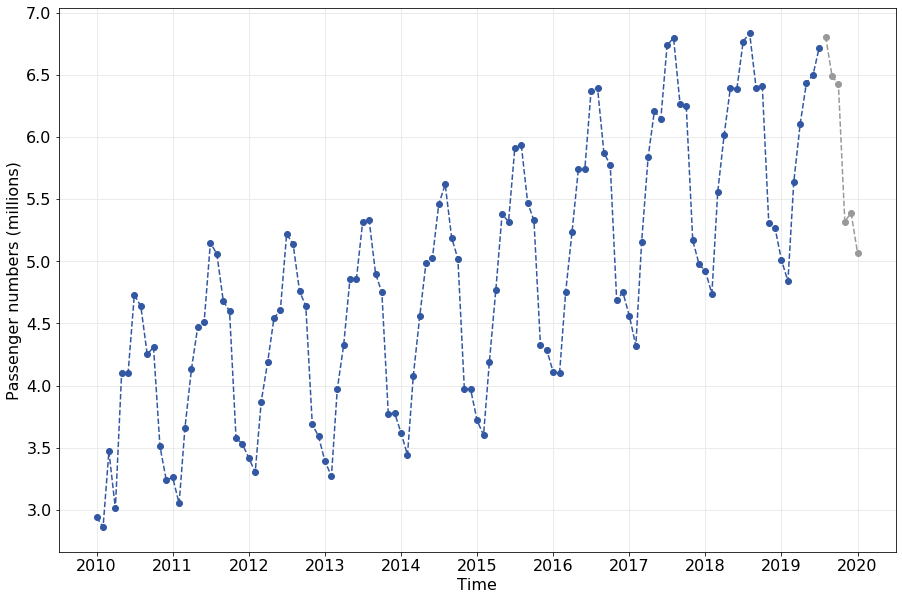

In [41]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.plot(schiphol_data, 'o--', color = kblue)
ax.plot(schiphol_data_held_back, 'o--', color = grey)
ax.set_xlabel('Time')
ax.set_ylabel('Passenger numbers (millions)')
ax.grid(True, color = [0.9, 0.9, 0.9, 0.1])
plt.savefig('./images/schiphol_data.png', bbox_inches = 'tight')
plt.show()

### Capturing trends and seasonality with prophet

In [24]:
# prophet needs data in a very specific format
proph_df = pd.DataFrame(data = {'ds':schiphol_data.index, 'y': [x[0] for x in schiphol_data.values]})
# fit prophet
m = Prophet(mcmc_samples=300)
m.fit(proph_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
forecast = m.predict(proph_df)

In [26]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-01,3.670591,2.585983,2.950282,3.593040,3.746769,-0.898130,-0.957763,-0.837989,-0.898130,-0.957763,-0.837989,0.0,0.0,0.0,2.772462
1,2010-02-01,3.697421,2.443109,2.797844,3.627527,3.767609,-1.075042,-1.140971,-1.002886,-1.075042,-1.140971,-1.002886,0.0,0.0,0.0,2.622379
2,2010-03-01,3.721654,3.139600,3.498481,3.656258,3.787784,-0.406748,-0.463888,-0.344596,-0.406748,-0.463888,-0.344596,0.0,0.0,0.0,3.314907
3,2010-04-01,3.748484,3.524107,3.878349,3.685469,3.809215,-0.043538,-0.101990,0.012945,-0.043538,-0.101990,0.012945,0.0,0.0,0.0,3.704946
4,2010-05-01,3.774448,4.026225,4.390844,3.716700,3.831248,0.438355,0.377932,0.496537,0.438355,0.377932,0.496537,0.0,0.0,0.0,4.212803


In [27]:
proph_df_plus_pred = pd.merge(proph_df.set_index('ds'), forecast.set_index('ds'), left_index=True, right_index=True).reset_index()
proph_df_plus_pred['y_m_trend'] = proph_df_plus_pred['y']-proph_df_plus_pred['trend']

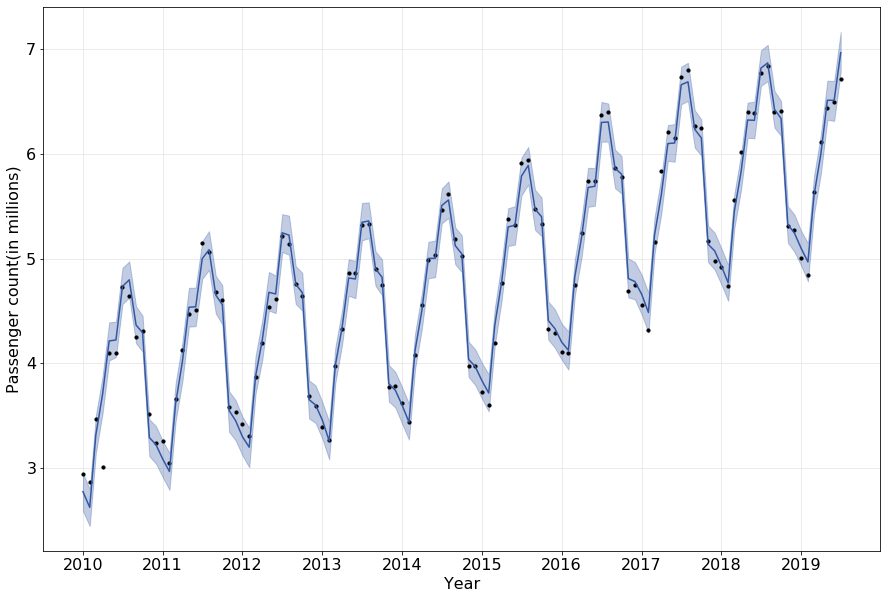

In [28]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.set_axisbelow(True)
ax.grid(True, color = [0.9, 0.9, 0.9, 0.1])
ax.fill_between(proph_df_plus_pred['ds'], proph_df_plus_pred['yhat_lower'], proph_df_plus_pred['yhat_upper'], color = kblue, alpha = 0.3)
ax.plot(proph_df_plus_pred['ds'], proph_df_plus_pred['yhat'], color = kblue)
ax.scatter(proph_df_plus_pred['ds'], proph_df_plus_pred['y'], color = 'k', s = 10)
ax.set_xlabel('Date')
ax.set_ylabel('Passenger count(in millions)')
plt.savefig('./images/schiphol_data_fit.png', bbox_inches = 'tight')
plt.show()

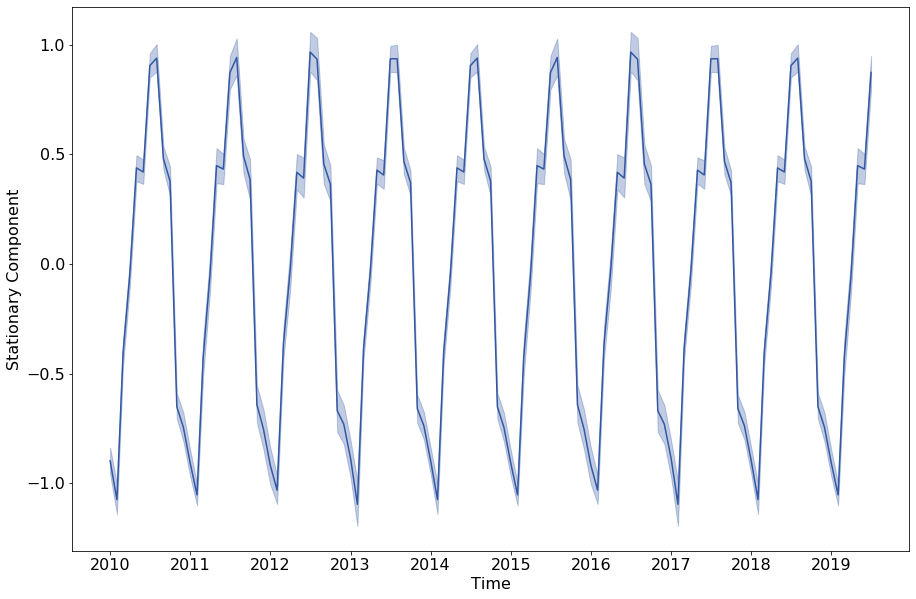

In [29]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.fill_between(proph_df_plus_pred['ds'], proph_df_plus_pred['yearly_lower'], proph_df_plus_pred['yearly_upper'], color = kblue, alpha = 0.3)
ax.plot(proph_df_plus_pred['ds'], proph_df_plus_pred['yearly'], color = kblue)
ax.set_xlabel('Date')
ax.set_ylabel('Stationary Component')
plt.savefig('./images/schiphol_data_stationary.png', bbox_inches = 'tight')
plt.show()

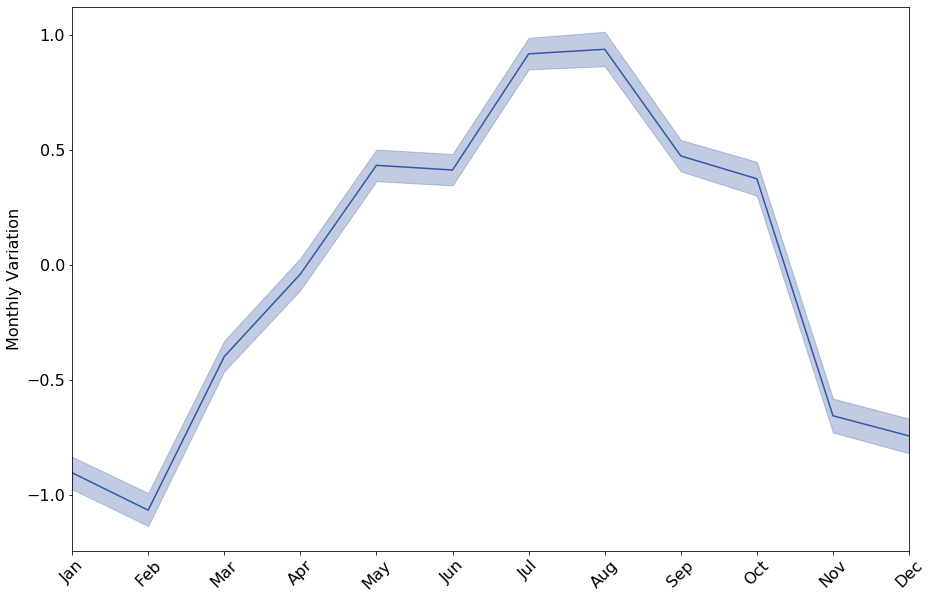

In [30]:
# Stationary Yearly 
yearly_pattern = proph_df_plus_pred['yearly'][:int(12*np.floor(len(proph_df_plus_pred)/12))].values
yearly_pattern_lower = proph_df_plus_pred['yearly_lower'][:int(12*np.floor(len(proph_df_plus_pred)/12))].values
yearly_pattern_upper = proph_df_plus_pred['yearly_upper'][:int(12*np.floor(len(proph_df_plus_pred)/12))].values
single_year = np.mean(yearly_pattern.reshape(int(len(yearly_pattern)/12),12), axis = 0)
single_year_lower = np.mean(yearly_pattern_lower.reshape(int(len(yearly_pattern)/12),12), axis = 0)
single_year_upper = np.mean(yearly_pattern_upper.reshape(int(len(yearly_pattern)/12),12), axis = 0)
single_year_std = np.std(yearly_pattern.reshape(int(len(yearly_pattern)/12),12), axis = 0)

fig, ax = plt.subplots(figsize = [15, 10])
month_array = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.fill_between(np.arange(0,len(month_array)), single_year_lower, single_year_upper, color = kblue, alpha = 0.3)
ax.plot(np.arange(0,len(month_array)), single_year,color = kblue)
ax.set_xticks(np.arange(0,len(month_array)))
ax.set_xticklabels(month_array, rotation = 45)
ax.set_ylabel('Monthly Variation')
ax.set_xlim(0, len(month_array)-1)
plt.savefig('./images/schiphol_data_monthly_variation.png', bbox_inches = 'tight')
plt.show()

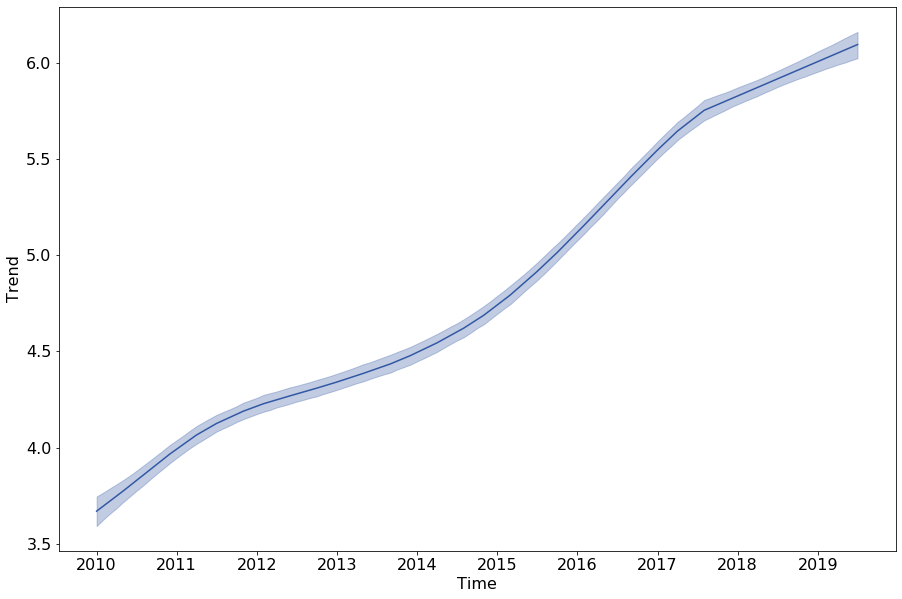

In [31]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.fill_between(proph_df_plus_pred['ds'], proph_df_plus_pred['trend_lower'], proph_df_plus_pred['trend_upper'], color = kblue, alpha = 0.3)
ax.plot(proph_df_plus_pred['ds'], proph_df_plus_pred['trend'], color = kblue)
ax.set_xlabel('Date')
ax.set_ylabel('Trend')
plt.savefig('./images/schiphol_data_trend.png', bbox_inches = 'tight')
plt.show()

### Predicting next n-months

In [38]:
# prophet needs data in a very specific format
proph_held_back_df = pd.DataFrame(data = {'ds':schiphol_data_held_back.index, 'y': [x[0] for x in schiphol_data_held_back.values]})
# forecast
forecast_held_back = m.predict(proph_held_back_df)
# add real data to forecast
proph_held_back_df_plus_pred = pd.merge(proph_held_back_df.set_index('ds'), forecast_held_back.set_index('ds'), left_index=True, right_index=True).reset_index()
# calculate rmse
rmse = np.sqrt(np.sum((proph_held_back_df_plus_pred['yhat'].values-proph_held_back_df_plus_pred['y'].values)**2))/np.sqrt(len(proph_held_back_df_plus_pred))

In [75]:
proph_held_back_df_plus_pred

,ds,y,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-08-01,6.81,6.107414,6.897466,7.187261,6.107410,6.107414,0.941530,0.941530,0.941530,0.941530,0.941530,0.941530,0.0,0.0,0.0,7.048944
1,2019-09-01,6.49,6.122474,6.477419,6.760157,6.121346,6.123214,0.490912,0.490912,0.490912,0.490912,0.490912,0.490912,0.0,0.0,0.0,6.613386
2,2019-10-01,6.43,6.137049,6.390455,6.662387,6.133705,6.139322,0.388294,0.388294,0.388294,0.388294,0.388294,0.388294,0.0,0.0,0.0,6.525343
3,2019-11-01,5.32,6.152109,5.373554,5.655526,6.146223,6.157030,-0.640656,-0.640656,-0.640656,-0.640656,-0.640656,-0.640656,0.0,0.0,0.0,5.511453
4,2019-12-01,5.39,6.166684,5.263716,5.555871,6.157557,6.173989,-0.753582,-0.753582,-0.753582,-0.753582,-0.753582,-0.753582,0.0,0.0,0.0,5.413102
5,2020-01-01,5.07,6.181744,5.121608,5.409623,6.168969,6.192306,-0.914023,-0.914023,-0.914023,-0.914023,-0.914023,-0.914023,0.0,0.0,0.0,5.267721


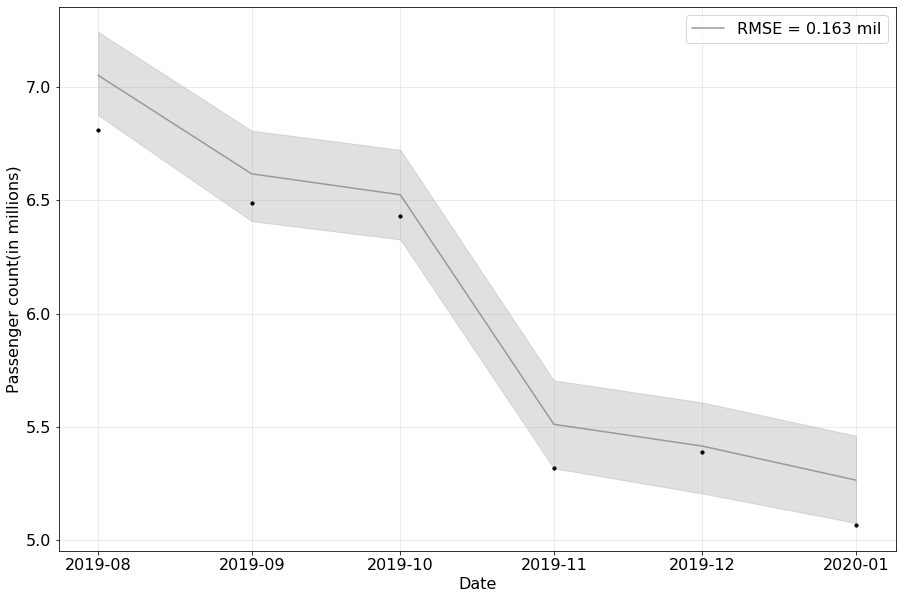

In [49]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.set_axisbelow(True)
ax.grid(True, color = [0.9, 0.9, 0.9, 0.1])
ax.fill_between(proph_held_back_df_plus_pred['ds'], proph_held_back_df_plus_pred['yhat_lower'], proph_held_back_df_plus_pred['yhat_upper'], color = grey, alpha = 0.3)
ax.plot(proph_held_back_df_plus_pred['ds'], proph_held_back_df_plus_pred['yhat'], color = grey, label = 'RMSE = {:.3f} mil'.format(rmse))
ax.scatter(proph_held_back_df_plus_pred['ds'], proph_held_back_df_plus_pred['y'], color = 'k', s = 10)
ax.set_xlabel('Date')
ax.set_ylabel('Passenger count(in millions)')
plt.savefig('./images/schiphol_data_fit_held_back.png', bbox_inches = 'tight')
plt.legend()
plt.show()